In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Scikit-learn with Transformers

In this notebook, I will show how you can use scikit-learn estimators with model weights from [🤗 Transformers](https://huggingface.co/docs/transformers/main/en/index) thanks to [whatlies](https://github.com/koaning/whatlies). We will later push our model with a model card using [skops](https://skops.readthedocs.org/) to Hugging Face Hub.

# Installing whatlies, datasets, scikit-learn and gradio

In [3]:
!pip install datasets
!pip install gradio
!pip install whatlies[transformers]
!pip install scikit-learn
!pip install skops

In [4]:
import datasets
import sklearn
import gradio as gr
import whatlies
from whatlies.language import HFTransformersLanguage
from transformers import pipeline
from sklearn.pipeline import Pipeline # yeah it's a bit confusing! 😅
from sklearn.linear_model import LogisticRegression

## Load and preprocess the dataset
We'll drop nan values, get rid of entries with 1024 characters for both simplicity and to fit gpt-2's conditions and convert them to list (as whatlies accepts lists).

In [5]:
train_set, test_set = datasets.load_dataset('imdb', split =['train[0:1000]+train[24000:25000]', 'test[0:1000]+test[24000:25000]'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
df_train = pd.DataFrame(train_set)
df_test = pd.DataFrame(test_set)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
df_train = df_train[df_train['text'].apply(lambda x: len(x) < 1024)]
df_test = df_test[df_test['text'].apply(lambda x: len(x) < 1024)]

In [7]:
X_train = df_train["text"].tolist()
y_train = df_train["label"].tolist()
X_test = df_test["text"].tolist()
y_test = df_test["label"].tolist()

# Setup classifier

We'll use gpt-2 weights.

In [8]:
pipe = Pipeline([
    ("embedding", HFTransformersLanguage("facebook/bart-base")),
    ("model", LogisticRegression())
])

## Visualizing pipeline and see the hyperparameters

In [9]:
from sklearn import set_config
set_config(display="diagram")
pipe

Pipeline(steps=[('embedding',
                 HFTransformersLanguage(model_name_or_path='facebook/bart-base')),
                ('model', LogisticRegression())])

In [10]:
pipe.get_params()

{'memory': None,
 'steps': [('embedding',
   HFTransformersLanguage(model_name_or_path='facebook/bart-base')),
  ('model', LogisticRegression())],
 'verbose': False,
 'embedding': HFTransformersLanguage(model_name_or_path='facebook/bart-base'),
 'model': LogisticRegression(),
 'embedding__model_name_or_path': 'facebook/bart-base',
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': None,
 'model__solver': 'lbfgs',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [11]:
pipe.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('embedding',
                 HFTransformersLanguage(model_name_or_path='facebook/bart-base')),
                ('model', LogisticRegression())])

In [12]:
y_pred = pipe.predict(X_test)

## Evaluation
Not bad :')

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       522
           1       0.89      0.85      0.87       550

    accuracy                           0.87      1072
   macro avg       0.87      0.87      0.87      1072
weighted avg       0.87      0.87      0.87      1072



## Now we will initialize a repository, create a model card and push it to 🤗Hub

In [19]:
import os
# create a directory for the repo
local_repo = "./local_repo_skops"
os.mkdir(local_repo) 

In [20]:
# save the model
import joblib
joblib.dump(pipe, "./pipeline.pkl")

['./pipeline.pkl']

In [21]:
from skops import card, hub_utils

# initialize the repository
# this will create a config file for reproducibility
hub_utils.init(
    model="pipeline.pkl",
    requirements=[f"scikit-learn={sklearn.__version__}"],
    dst=local_repo,
    task="text-classification",
    data=X_test,
)

We will now create the model card. Passing `card.metadata_from_config` to metadata will fill metadata section automatically.

In [22]:
model_card = card.Card(pipe, metadata=card.metadata_from_config(local_repo))

Let's add some information to our model card!

In [23]:
model_card.add(model_description="This is a logistic regression model trained with GPT-2 embeddings on imdb dataset.")
model_card.add(limitations="This model is trained for educational purposes.")

Card(
  model=Pipeline(steps=[('embedding',...), ('model', LogisticRegression())]),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'text-classification'],
  model_description='This is a logist...h GPT-2 embeddings on imdb dataset.',
  limitations='This model is trained for educational purposes.',
)

We will evaluate the model and add evaluation results to our card.

In [24]:
# use f1 to evaluate our model
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average="macro")
model_card.add_metrics(**{"f1_score": f1})
# add explanation
model_card.add(eval_method="The model is evaluated on test data using F1-score with macro avg.")

Card(
  model=Pipeline(steps=[('embedding',...), ('model', LogisticRegression())]),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'text-classification'],
  model_description='This is a logist...h GPT-2 embeddings on imdb dataset.',
  limitations='This model is trained for educational purposes.',
  eval_method='The model is evaluated...data using F1-score with macro avg.',
)

We can conveniently add plots using `add_plot` method.

Card(
  model=Pipeline(steps=[('embedding',...), ('model', LogisticRegression())]),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'text-classification'],
  model_description='This is a logist...h GPT-2 embeddings on imdb dataset.',
  limitations='This model is trained for educational purposes.',
  eval_method='The model is evaluated...data using F1-score with macro avg.',
  Confusion matrix='confusion_matrix.png',
)

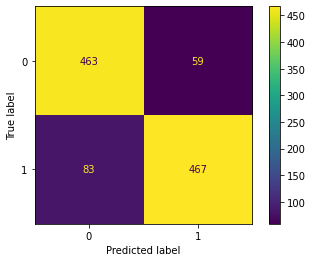

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()

# we have to save the figure and pass it to add_plot
disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
model_card.add_plot(**{"Confusion matrix": "confusion_matrix.png"})

Save our card.

In [26]:
model_card.save(Path(local_repo) / "README.md")

We now should have our model card, configuration file, our model and plot.

In [27]:
os.listdir(local_repo)

['README.md', 'pipeline.pkl', 'config.json', 'confusion_matrix.png']

Let's push our model to 🤗Hub! 
Firstly, we need to authenticate ourselves and then push the model to the Hub.

In [28]:
from huggingface_hub import notebook_login
notebook_login()

In [29]:
# if the repository doesn't exist we can create using `create_remote`
hub_utils.push(repo_id = "scikit-learn/transformers-imdb",
              source = local_repo,
              create_remote = True)

You can find the repository [here](https://huggingface.co/scikit-learn/transformers-imdb).
Some useful links if you're interested:
- [Skops docs](https://skops.readthedocs.io/en/stable/)
- [Skops GitHub](https://github.com/skops-dev/skops)
- [Whatlies GitHub](https://github.com/koaning/whatlies)